## Two-dimensional advection equation

We want to solve the following PDE:

\begin{equation}
    \frac{\partial \phi}{\partial t} + u \frac{\partial \phi}{\partial x} + v \frac{\partial \phi}{\partial y} = 0
\end{equation}

The independen variables (i.e, $x$, $y$ and $t$) are used as input values for the NN, and the solution (i.e. $\phi(x,y,t)$) is the output. In order to find the solution, at each step the NN outputs are derived w.r.t the inputs. Then, a loss function that matches the PDE is built and the weights are updated accordingly. If the loss function goes to zero, we can assume that our NN is indeed the solution to our PDE. We will try to find a general solution for different values of $u$, so it will be set also as an input.

In [ ]:
# autoreload nangs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import math
import numpy as np 
import matplotlib.pyplot as plt 

import torch
cuda = True
device = "cuda" if torch.cuda.is_available() and cuda else "cpu"

First we define our PDE and set the values for training.

In [ ]:
from nangs.pde import PDE
from nangs.bocos import PeriodicBoco, DirichletBoco

class MyPDE(PDE):
    def __init__(self, inputs=None, outputs=None, params=None):
        super().__init__(inputs, outputs, params)
    def computePDELoss(self, grads, inputs, outputs, params): 
        dpdt, dpdx, dpdy = grads['p']['t'], grads['p']['x'], grads['p']['y']
        u, v = params['u'], params['v']
        return [dpdt + u*dpdx + v*dpdy]

# instanciate pde
pde = MyPDE(inputs=['x', 'y', 't'], outputs=['p'], params=['u', 'v'])

# define input values
x = np.linspace(0,1,20)
y = np.linspace(0,1,20)
t = np.linspace(0,1,20)
u = np.array([1.0])
v = np.array([1.0])

pde.setValues({'x': x, 'y': y, 't': t, 'u': u, 'v': v})
pde.setValues({'x': x, 'y': y, 't': t}, train=False)

Boundary conditions.

In [ ]:
# periodic b.c for the space dimension
x1, x2 = np.array([0]), np.array([1])
boco = PeriodicBoco('boco_x', {'x': x1, 'y': y, 't': t}, {'x': x2, 'y':y, 't': t})
pde.addBoco(boco)

y1, y2 = np.array([0]), np.array([1])
boco = PeriodicBoco('boco_y', {'x': x, 'y': y1, 't': t}, {'x': x, 'y':y2, 't': t})
pde.addBoco(boco)

# initial condition (dirichlet for temporal dimension)
p0 = np.zeros((len(y)*len(x)))
for i, _y in enumerate(y):
    for j, _x in enumerate(x):
        p0[i*len(x) + j] = math.sin(2.*math.pi*_x)*math.sin(2.*math.pi*_y)
        
boco = DirichletBoco('initial_condition', {'x': x, 'y': y, 't': np.array([0])}, {'p': p0})
pde.addBoco(boco)

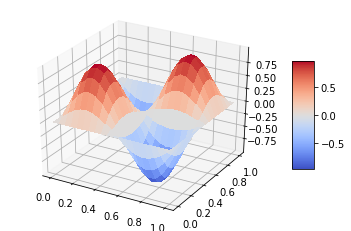

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x, y)
surf = ax.plot_surface(X, Y, p0.reshape((len(y),len(x))), cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

Now we define a topology for our solution and set the training parameters. Then we can find a solution for our PDE.

In [ ]:
# define solution topology
topo = {'layers': 5, 'neurons': 512, 'activations': 'relu'}
pde.buildSolution(topo)

# set optimization parameters
pde.compile()

In [ ]:
# find the solution
hist = pde.solve(device, 'adv2d_best.pth') 

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


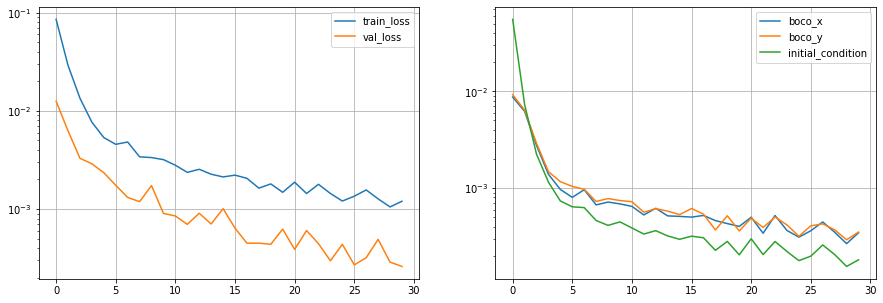

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(hist['train_loss'], label="train_loss")
ax1.plot(hist['val_loss'], label="val_loss")
ax1.grid(True)
ax1.legend()
ax1.set_yscale("log")
for boco in pde.bocos:
    ax2.plot(hist['bocos'][boco.name], label=boco.name)
ax2.legend()
ax2.grid(True)
ax2.set_yscale("log")
plt.show()

Finally, we can evaluate our solution.

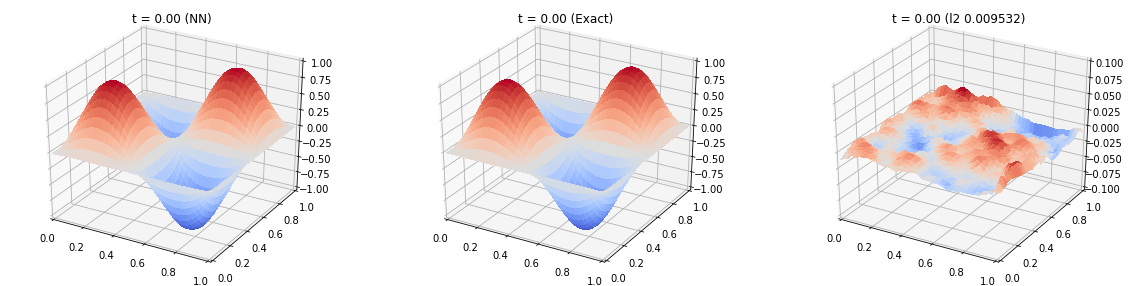

In [ ]:
# evaluate the solution
pde.load_state_dict('adv2d_best.pth')
x = np.linspace(0,1,40)
y = np.linspace(0,1,40)
t = np.linspace(0,1,40)
u, v = np.array([1]), np.array([1])
p, p0, l2 = [], [], []
for _t in t:
    _p0 = np.zeros((len(y)*len(x)))
    for i, _y in enumerate(y):
        for j, _x in enumerate(x):
            _p0[i*len(x) + j] = math.sin(2.*math.pi*(_x-u*_t))*math.sin(2.*math.pi*(_y-v*_t))
    pde.evaluate({'x': x, 'y': y, 't': np.array([_t])}, device)
    _p = pde.outputs['p']
    _l2 = np.sqrt(np.mean((_p - _p0)**2))
    p.append(_p)
    p0.append(_p0)
    l2.append(_l2)

from matplotlib import animation, rc
rc('animation', html='html5')

def plot(ax1, ax2, ax3, p, p0, t, l2):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    tit1 = ax1.set_title(f't = {t:.2f} (NN)')
    tit2 = ax2.set_title(f't = {t:.2f} (Exact)')
    tit3 = ax3.set_title(f't = {t:.2f} (l2 {l2:5f})')
    X, Y = np.meshgrid(x, y)
    ax1.plot_surface(X, Y, p.reshape((len(y),len(x))), cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax1.set_xlim([0,1])
    ax1.set_ylim([0,1])
    ax1.set_zlim([-1,1])
    ax2.plot_surface(X, Y, p0.reshape((len(y),len(x))), cmap=cm.coolwarm,  linewidth=0, antialiased=False)
    ax2.set_xlim([0,1])
    ax2.set_ylim([0,1])
    ax2.set_zlim([-1,1])
    ax3.plot_surface(X, Y, p.reshape((len(y),len(x)))-p0.reshape((len(y),len(x))), cmap=cm.coolwarm,  linewidth=0, antialiased=False)
    ax3.set_xlim([0,1])
    ax3.set_ylim([0,1])
    ax3.set_zlim([-0.1,0.1])
    return [tit1, tit2, tit3]

def get_anim(fig, ax1, ax2, ax3, p, p0, t, l2):
    def anim(i):
        return plot(ax1, ax2, ax3, p[i], p0[i], t[i], l2[i])
    return anim
    
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
animate = get_anim(fig, ax1, ax2, ax3, p, p0, t, l2)
anim = animation.FuncAnimation(fig, animate, frames=len(t), interval=300, blit=True)

In [ ]:
anim